In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from __future__ import division

In [2]:
x=pd.read_excel("var3.xls") #ростелеком

In [3]:
x.head()

,Date,BID,ASK,Open price,Min,Max,Close price,AVG,Oborot,Amount of deals
0,30.04.2018,62.36,62.39,62.58,62.15,62.58,62.36,62.34,3865217,121
1,28.04.2018,62.39,62.40,62.46,62.01,62.46,62.40,62.29,7088105,328
2,27.04.2018,62.35,62.38,62.50,62.18,62.50,62.38,62.34,5835215,209
3,26.04.2018,62.31,62.43,62.38,62.17,62.49,62.34,62.31,8125190,145
4,25.04.2018,62.25,62.30,62.50,62.15,62.50,62.25,62.29,11262339,188


In [4]:
x.columns.get_values

<bound method Index.get_values of Index([u'Date', u'BID', u'ASK', u'Open price', u'Min', u'Max', u'Close price',
       u'AVG', u'Oborot', u'Amount of deals'],
      dtype='object')>

In [5]:
# визуализация исходных данных

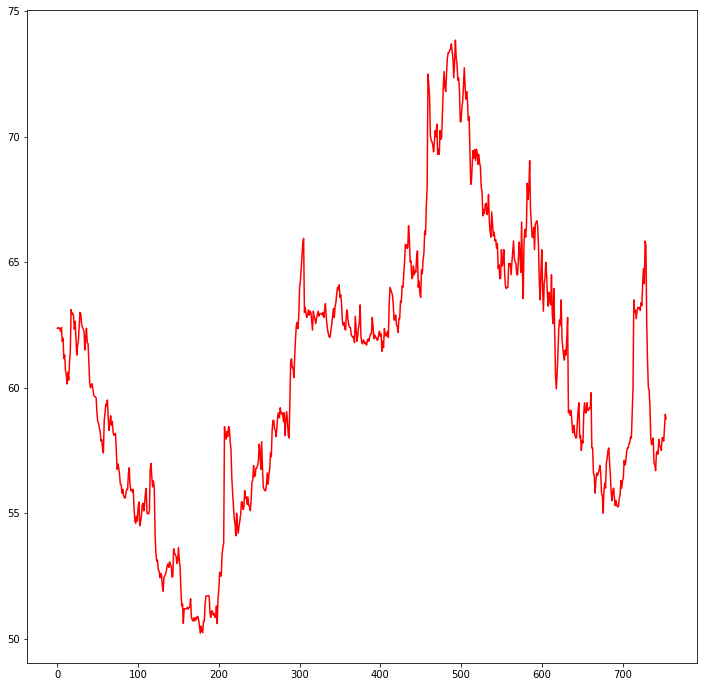

In [6]:
plt.figure(figsize=(12,12))
plt.plot(range(0, 755), x["Close price"], 'red')
plt.show()

In [28]:
### rolling_mean_data - rolling mean of close price array
### rolling_mean_window - parametr of rolling mean
### min_size - minimum size of time series for train dataset 
### eps - bound of 'plato'  
class finance:
    def __init__(self, k_neighbors = 5, rolling_mean_window = 4, min_size = 3, eps = 0.01, metrics = 'euclidean'):
        self.rolling_mean_window = rolling_mean_window
        self.min_size = min_size
        self.eps = eps
        self.metrics = metrics
        self.k = k_neighbors
        if self.metrics == 'euclidean':
            self.distance = self.euclidean_distance
    
    def rolling_mean(self, data):
        self.rolling_mean_data = np.nan_to_num(data.rolling(self.rolling_mean_window).mean())
    
    def get_kinks(self):
        kinks=[0]
        for i in range(1, len(self.rolling_mean_data) - 1):
            if(self.rolling_mean_data[i]-self.rolling_mean_data[i-1])*(self.rolling_mean_data[i] - self.rolling_mean_data[i+1])>0:
                kinks.append(i)
        self.kinks = kinks
        
    def make_marks(self, x):
        if len(x) > 1:
            if abs(np.max(x) - np.min(x)) < self.eps:
                return 0
            else:
                return np.sign(x[0] - x[-1])
        else:
            print 'Error: some length of interval <= 1'
    
    def extract_features(self, data, index):
        features = []
        for i in range(index, index + len(data)):
            features.append([data['Close price'][i] - data['Open price'][i], data['Max'][i] - data['Min'][i], \
                            data['Max'][i] / data['Min'][i], data['Close price'][i] / data['Open price'][i], \
                            np.sign(data['Close price'][i] - data['Open price'][i])])   
        return features      
    
    def make_dataset(self, data):
        dataset = []
        marks = []
        for i in range(1, len(self.kinks)):
            if self.kinks[i] - self.kinks[i-1] >= self.min_size:
                dataset.append(self.extract_features(data[self.kinks[i-1] : self.kinks[i]], self.kinks[i-1]))
                marks.append(self.make_marks(self.rolling_mean_data[self.kinks[i-1] : self.kinks[i]]))
        marks.append(self.make_marks(self.rolling_mean_data[self.kinks[-1]:]))    
        # delete a little series               
        # make target
        target = marks[1:]
        return dataset, target
        
    def euclidean_distance(self, x, y):
        x = np.array(x)
        y = np.array(y)
        return np.sqrt(np.sum((x-y)**2))
    
    # when we want to predict future, we should not look there
    def right_split(self, X, y, test_size = 0.25):
        size = int(len(y) * (1 - test_size))
        X_train , y_train = X[:size], y[:size] 
        X_test , y_test = X[size:], y[size:]
        return X_train, X_test, y_train, y_test 
    
    def prepare_data(self, data):
        self.rolling_mean(data['Close price'])
        self.get_kinks()
        dataset, target = self.make_dataset(data)
        return dataset, target
    
    def predict(self, X_train, y_train, x):
        distance_list = []
        for x_train in X_train:
            min_size = min(len(x), len(x_train))
            distance_list.append(self.distance(x[len(x) - min_size : ], x_train[len(x_train) - min_size : ]))
        index = np.argsort(distance_list)[:self.k]
        marks = np.array(y_train)[index]
        marks , count = np.unique(marks, return_counts = True)
        return marks[np.argmax(count)]
        
    def fit_predict(self, X_train, y_train, X_test):
        pred = []
        for x in X_test:
            pred.append(self.predict(X_train, y_train, x))
        return pred
    
    def cross_predict(self, X_train, y_train, x):
        distance_list = []
        for x_train in X_train:
            min_size = min(len(x), len(x_train))
            distance_list.append(self.distance(x[len(x) - min_size : ], x_train[len(x_train) - min_size : ]))
        index = np.argsort(distance_list)[1:self.k + 1]
        marks = np.array(y_train)[index]
        marks , count = np.unique(marks, return_counts = True)
        return marks[np.argmax(count)]
    
    def KNN_cross_validation(self, X, y):
        pred = []
        for x in X:
            pred.append(self.cross_predict(X, y, x))
        return pred
    
    def check(self, y_predict, y_right):
        count_sum = 0
        for i in range(len(y_predict)):
            if y_predict[i] == y_right[i]:
                count_sum += 1
        return count_sum / len(y_predict)       
            
        

In [17]:
#sample example
first_rocket = finance(rolling_mean_window=3)
data, target = first_rocket.prepare_data(x)
pred = first_rocket.KNN_cross_validation(data, target)
first_rocket.check(pred, target)

0.5803571428571429

In [29]:
# selection the best parametrs 
statistic = np.zeros((72, 5))
rolling_mean_window = [2, 3, 4]
k_mean = [3, 4, 5, 6, 7, 8]
min_size = [2, 3, 4, 5]
i = 0
for rol in rolling_mean_window:
    for k in k_mean:
        for m in min_size:
            first_rocket = finance(rolling_mean_window=rol, min_size = m, k_neighbors = k)
            data, target = first_rocket.prepare_data(x)
            pred = first_rocket.KNN_cross_validation(data, target)
            statistic[i] =  np.array([int(rol), int(k), int(m), first_rocket.check(pred, target), int(len(target))])
            i += 1
            

In [30]:
temp_index = np.argsort(statistic[:, 3])
new_stat = statistic[temp_index]
new_stat[-1:]

array([[ 4.        ,  6.        ,  3.        ,  0.66304348, 92.        ]])

In [31]:
table = pd.DataFrame(statistic, columns=['rolling mean window', 'k neighbors', 'min size', 'result', 'size of data'])

In [32]:
table

,rolling mean window,k neighbors,min size,result,size of data
0,2.0,3.0,2.0,0.539773,176.0
1,2.0,3.0,3.0,0.516667,120.0
2,2.0,3.0,4.0,0.487500,80.0
3,2.0,3.0,5.0,0.538462,52.0
4,2.0,4.0,2.0,0.539773,176.0
5,2.0,4.0,3.0,0.516667,120.0
6,2.0,4.0,4.0,0.525000,80.0
7,2.0,4.0,5.0,0.461538,52.0
8,2.0,5.0,2.0,0.602273,176.0
9,2.0,5.0,3.0,0.558333,120.0


In [33]:
np.sort(table['result'])

array([0.39344262, 0.40983607, 0.44262295, 0.44262295, 0.45901639,
       0.46153846, 0.47747748, 0.48076923, 0.48076923, 0.4875    ,
       0.49180328, 0.5       , 0.5       , 0.5       , 0.5125    ,
       0.51666667, 0.51666667, 0.52173913, 0.525     , 0.525     ,
       0.52678571, 0.53030303, 0.53333333, 0.53333333, 0.53571429,
       0.53846154, 0.53846154, 0.53977273, 0.53977273, 0.54054054,
       0.54545455, 0.55      , 0.55      , 0.55294118, 0.55357143,
       0.55769231, 0.55833333, 0.5625    , 0.56470588, 0.56521739,
       0.56756757, 0.57575758, 0.57575758, 0.57647059, 0.57657658,
       0.57954545, 0.57971014, 0.58035714, 0.58695652, 0.58695652,
       0.58695652, 0.58823529, 0.58974359, 0.58974359, 0.58974359,
       0.59459459, 0.59782609, 0.60227273, 0.6025641 , 0.6036036 ,
       0.60714286, 0.60795455, 0.60869565, 0.61176471, 0.61956522,
       0.62318841, 0.62352941, 0.625     , 0.63768116, 0.65384615,
       0.65384615, 0.66304348])

In [26]:
table.to_excel('stat_rostelecom.xlsx')